In [26]:
import os
import editdistance
import torch
import torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
DATASET_PATH = os.path.join('morse_dataset', 'morse_dataset')
PREPROCESS = False
TRAIN = False
DEBUG = False

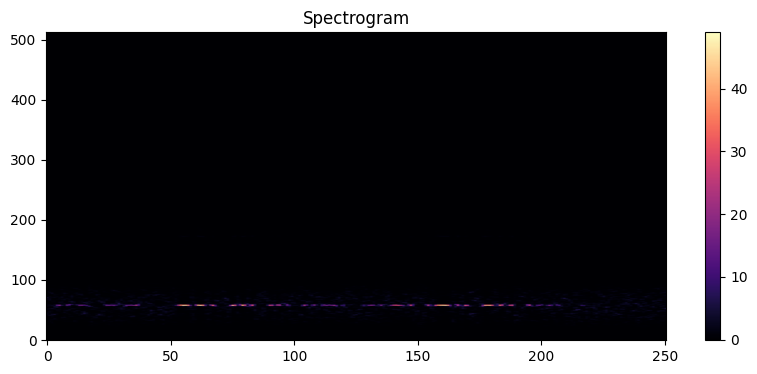

In [28]:
from morse import MorsePreprocessing

waveform, sample_rate = torchaudio.load(os.path.join(DATASET_PATH, '21600.opus'))

transform = MorsePreprocessing()
spec = transform(waveform)

plt.figure(figsize=(10, 4))
plt.imshow(spec[0,:,:].numpy(), aspect='auto', origin='lower', cmap='magma')
plt.title('Spectrogram')
plt.colorbar()
plt.show()

In [29]:
from preprocessing import preprocess_dataset

df = pd.read_csv('train.csv')
labels_dict = {
        f"{row['id']}": row['message']
        for _, row in df.iterrows()
    }

if PREPROCESS:
    preprocess_dataset(DATASET_PATH, "data_preprocessed", labels_dict, transform)

In [30]:
from preprocessing import PreprocessedDataset
from morse import SpecAugment

c2i = {
    '<blank>': 0,
    '.': 1,
    '-': 2,
    ' ': 3,
    '/': 4
}
i2c = {v: k for k, v in c2i.items()}

train_dataset = PreprocessedDataset('data_preprocessed/train', c2i, transform=SpecAugment())
val_dataset = PreprocessedDataset('data_preprocessed/val', c2i)

In [31]:
import torch
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    features, targets, input_lengths, target_lengths = zip(*batch)

    features = [f.transpose(0, 1) for f in features]

    padded_features = pad_sequence(features, batch_first=True)
    padded_targets = torch.cat(targets)

    input_lengths = torch.tensor([f.shape[0] for f in features], dtype=torch.long)
    target_lengths = torch.tensor(target_lengths, dtype=torch.long)

    return padded_features, padded_targets, input_lengths, target_lengths

In [32]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=256,
    shuffle=True,
    collate_fn=collate_fn,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=256,
    shuffle=True,
    collate_fn=collate_fn,
)

In [33]:
from morse import MorseConformer

model = MorseConformer(
    input_dim=513,
    output_dim=5,
    #num_layers=6,
    #num_heads=4
).to('cuda')

In [34]:
from train import train
from train import cross_val_scores

if DEBUG:
    scores = cross_val_scores(model, train_dataset, train, collate_fn, num_epochs=100, patience=5)
    
    print(f'Scores: {scores}')
    print(f'Mean: {np.mean(scores)}')
    print(f'Std: {np.std(scores)}')

In [35]:
if TRAIN:
    train(model=model, train_loader=train_loader, val_loader=val_loader, num_epochs=100, patience=5)

model.load_state_dict(torch.load('models/best_model.pt', map_location='cuda'))

<All keys matched successfully>

In [36]:
from torchaudio.models.decoder import ctc_decoder

labels = list(c2i.keys())
decoder = ctc_decoder(
    lexicon=None,
    tokens=labels,
    beam_size=10,
    blank_token='<blank>',
    unk_word='<blank>',
    sil_token='<blank>'
)

In [37]:
from preprocessing import preprocess_audio
from preprocessing import decode_from_morse
from torch.nn.functional import log_softmax

def submit():
    model.eval()
    submission = []
    
    target_files = sorted([
        f for f in os.listdir(DATASET_PATH)
        if f.endswith('.opus') and 30001 <= int(os.path.splitext(f)[0]) <= 35000
    ], key=lambda x: int(os.path.splitext(x)[0]))
    
    with torch.no_grad():
        for fname in target_files:
            path = os.path.join(DATASET_PATH, fname)
            mel = preprocess_audio(path, transform)
            mel = mel.transpose(0, 1).unsqueeze(0).to('cuda')
            input_len = torch.tensor([mel.shape[1]], device='cuda')
    
            logits = model(mel)
            log_probs = log_softmax(logits, dim=-1)
            log_probs_btc = log_probs.transpose(0, 1)
            
            decoded_output = decoder(log_probs_btc.cpu(), input_len.cpu())
            decoded_morse = ''.join([labels[token.item()] for token in decoded_output[0][0].tokens])
            decoded_text = decode_from_morse(decoded_morse)
    
            submission.append({
                "id": fname,
                "message": decoded_text
            })
    
    df = pd.DataFrame(submission)
    df.to_csv("submission.csv", index=False)

submit()

In [38]:
from preprocessing import decode_from_morse
from torch.nn.functional import log_softmax
from torch.nn import CTCLoss

model.eval()
ctc_loss_fn = CTCLoss(blank=0, zero_infinity=True)
val_losses = []
levenshtein_scores = []

with torch.no_grad():
    for features, targets, input_lengths, target_lengths in val_loader:
        features = features.to('cuda')
        targets = targets.to('cuda')
        input_lengths = input_lengths.to('cuda')
        target_lengths = target_lengths.to('cuda')
        
        log_probs = model(features, input_lengths)
        log_probs = log_softmax(log_probs, dim=-1)
        
        loss = ctc_loss_fn(log_probs, targets, input_lengths, target_lengths)
        val_losses.append(loss.item())
        
        log_probs_btc = log_probs.transpose(0, 1)
        
        decoded_output = decoder(log_probs_btc.cpu().contiguous(), input_lengths.cpu())
        decoded_batch = [''.join([labels[token.item()] for token in hypo[0].tokens]) for hypo in decoded_output]
        target_batch = []
        start = 0
        
        for length in target_lengths:
            length = int(length)
            target_seq = targets[start:start + length]
            text = ''.join([i2c[int(c)] for c in target_seq])
            target_batch.append(text)
            start += length
        
        for pred, true in zip(decoded_batch, target_batch):
            dist = editdistance.eval(decode_from_morse(pred), decode_from_morse(true))
            levenshtein_scores.append(dist)

mean_val_loss = sum(val_losses) / len(val_loader)
mean_levenshtein = sum(levenshtein_scores) / len(levenshtein_scores)

print(f"Val CTC Loss: {mean_val_loss:.4f}")
print(f"Mean Levenshtein: {mean_levenshtein:.4f}")

Val CTC Loss: 0.0309
Mean Levenshtein: 0.3402


In [40]:
total_files = 35000

for file in range(total_files - 16, total_files + 1):
    path = os.path.join(DATASET_PATH, f'{file}.opus')

    waveform, sample_rate = torchaudio.load(path)

    mel = transform(waveform).squeeze(0)
    mel = mel.transpose(0, 1).unsqueeze(0).to('cuda')
    input_len = torch.tensor([mel.shape[1]], device='cuda')

    logits = model(mel)
    log_probs = log_softmax(logits, dim=-1)
    log_probs_btc = log_probs.transpose(0, 1)

    decoded_output = decoder(log_probs_btc.cpu(), input_len.cpu())
    decoded_morse = ''.join([labels[token.item()] for token in decoded_output[0][0].tokens])
    decoded_text = decode_from_morse(decoded_morse)

    print(f"{file}.opus,{decoded_text}")

34984.opus,ДАМНАМОТИ НСЫАМЦ
34985.opus,ИЛ ЬСВЕДТКЧВНТИ ЯМДМЫМЮНЯМЦ ЮТИЫМ ЬТКТЧМЫН ДТЫМРГЗ ЕПИГ
34986.opus,АНХ ВСОЕГЬ Р ВКТДАМИ НКШМДНИ ГЕКНЖТА
34987.opus,ИЛ ДАСДП ЬСОЕМУНТИ ИГВКСОЕП ЬКСХЫСУС ХНУЮН ХНУСИ
34988.opus,ЕТЬТКП ДСЯНКМЫОЦ ИМК
34989.opus,КНОЬКМ СОЕНЫМОП ЬСЮНВМ
34990.opus,ИЛ ЬСОЕНДМЫМ ЙЫНУС ЙЫМЧАТУС ЬКТДЛХТ ЫМЖАЛШ ДЛУСВ М ЧТЫНАМБ
34991.opus,ИЛ ДАСДП ОСЮВНЫМ НЮЙГРГ ЕТЫТУКНЩН
34992.opus,АС АТ ИСЧТИ КГЖНЕПОЦ ЮН НЙОСЫЗЕЗ ДТКАСОЕП ОМИДСЫСД
34993.opus,ТОЫМ ДЛ ОЫЛХМЕТ #ЕС ЬСОЫНАМТ ЕС СЕРЫМРАМЕТОП
34994.opus,АН ЖНОЕСЕТ ЬТКТВНЖМ ГДТЫМЖТААСБ АН 75 РМЫСЯМРЫСД
34995.opus,ОДЦЮП ЬСВВТКЧМДНТЕОЦ ДКГЖАГЗ АТГЕСИМИЛИМ ЬНЫПЯНИМ АНХМШ СЬТКНЕСКСД
34996.opus,ОРСКС ИЛ ДАСДП ЬСОЕМУАТИ ЕНБАЛ КНРТЕАЛШ ВДМУНЕТЫТБ
34997.opus,ОИСЧТИ СЕЬКНДМЕП ЮН ДНИМ ОЬНОМЕТЫПАЛБ ЖТЫАСР
34998.opus,ТОЫМ ДЛ ЬСЧТЫНТЕТ ДТКАГЕПОЦ ВСИСБ НН
34999.opus,ОДТЕ ОСЫАЯН ВНКМЕ ЧМЮАП РНЧВСИГ
35000.opus,РСАТЯ ЬТКТВНЖМ
